# Exploratory Analysis of GTD 

*Zoe Wang • qianranw@gmail.com • 7/11/2017*

In [1]:
# Pandas, numpy, random
import pandas as pd
import numpy as np
import random

# Plots
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

# skleanrn
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Check Data

In [2]:
# load txt file into pandas data frame
gtd = pd.read_excel('globalterrorismdb_0616dist.xlsx')

In [3]:
# take a look of gtd data frame
pd.set_option('display.max_columns', 137)
gtd.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,ingroup,ingroup2,ingroup3,gsubname3,motive,guncertain1,guncertain2,guncertain3,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,0,0,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1,0,NaN,NaN,1,1,1,0.0,NaN,.,0,1,0,1,Assassination,NaN,.,NaN,.,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,.,NaN,.,NaN,NaN,NaN,.,NaN,.,NaN,.,NaN,NaN,NaN,.,MANO-D,NaN,NaN,NaN,NaN,3629,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,.,NaN,NaN,.,NaN,13,Unknown,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,.,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1,0,NaN,NaN,1,1,1,0.0,NaN,.,0,1,0,6,Hostage Taking (Kidnapping),NaN,.,NaN,.,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,.,NaN,.,NaN,NaN,NaN,.,NaN,.,NaN,.,NaN,NaN,NaN,.,23rd of September Communist League,NaN,NaN,NaN,NaN,3330,NaN,NaN,NaN,NaN,0.0,NaN,NaN,7.0,NaN,NaN,NaN,.,NaN,NaN,.,NaN,NaN,.,NaN,13,Unknown,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,.,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4,0,NaN,NaN,1,1,1,0.0,NaN,.,0,1,0,1,Assassination,NaN,.,NaN,.,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,.,NaN,.,NaN,NaN,NaN,.,NaN,.,NaN,.,NaN,NaN,NaN,.,Unknown,NaN,NaN,NaN,NaN,-9,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,.,NaN,NaN,.,NaN,13,Unknown,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,.,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1,0,NaN,NaN,1,1,1,0.0,NaN,.,0,1,0,3,Bombing/Explosion,NaN,.,NaN,.,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,.,NaN,.,NaN,NaN,NaN,.,NaN,.,NaN,.,NaN,NaN,NaN,.,Unknown,NaN,NaN,NaN,NaN,-9,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,.,NaN,NaN,.,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,NaN,.,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,.,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,19

## 2. Data Preprocessing

### 2.1  Create Sub Dataframe

This dataset contains 137 features and lots of them contains more than half null values. Therefore, I will create a sub dataframe which certains features I think are more relavant to the prediction. 

In [4]:
gtd.shape

(156772, 137)

In [5]:
# Create sub_gtd dataframe with certain columns
sub_gtd = gtd[['eventid', 'iyear', 'imonth', 'extended', 'crit1', 'crit2', 'crit3',
              'doubtterr', 'alternative', 'multiple', 'country', 'region',
              'vicinity', 'specificity', 'attacktype1', 'attacktype2', 'attacktype3',
              'success', 'suicide', 'weaptype1', 'weapsubtype1', 'weaptype2', 'weapsubtype2', 
               'weaptype3', 'weapsubtype3', 'targtype1', 'targsubtype1', 'natlty1',
               'targtype2', 'targsubtype2', 'natlty2', 'targtype3', 'targsubtype3', 'natlty3',
               'nperps', 'nperpcap', 'property', 'propextent', 'ishostkid', 'nhostkid', 'nhours', 'ndays',
               'hostkidoutcome', 'nreleased', 'ransom', 'ransomamt', 'ransompaid',
               'INT_LOG', 'INT_IDEO','INT_MISC', 'INT_ANY',
               'gname']]

# Extract date from eventid
sub_gtd.eventid = sub_gtd.eventid.apply(str)
sub_gtd['date'] = sub_gtd.eventid.str[:8]

# Drop column eventid
sub_gtd.drop('eventid', axis = 1, inplace = True)

In [6]:
sub_gtd.shape

(156772, 52)

### 2.2 Null Values

Except for gname, all columns I selected are categorical values, some of them contain null values since the situation is not compatible or the result was unknown. I replaced null values with 0, -9, or -99 based on the instruction on the code book. 

In [7]:
# Columns with null values
sub_gtd.columns[sub_gtd.isnull().any()]

Index([u'doubtterr', u'alternative', u'attacktype2', u'attacktype3',
       u'weapsubtype1', u'weaptype2', u'weapsubtype2', u'weaptype3',
       u'weapsubtype3', u'targsubtype1', u'natlty1', u'targtype2',
       u'targsubtype2', u'natlty2', u'targtype3', u'targsubtype3', u'natlty3',
       u'nperps', u'nperpcap', u'propextent', u'ishostkid', u'nhostkid',
       u'nhours', u'ndays', u'hostkidoutcome', u'nreleased', u'ransom',
       u'ransomamt', u'ransompaid'],
      dtype='object')

In [8]:
# Only one record has null value in [doubtterr], it's safe to drop that one
# sub_gtd.doubtterr.isnull().sum()
sub_gtd = sub_gtd[sub_gtd.doubtterr.notnull()]

# When [doubtterr] is 1, [alternative] has values 1, 2, 3, 4, or 5. Otherwise its nan. Fill nan with 0.
sub_gtd.alternative.fillna(0, inplace = True)

# Most records have nan values in [attacktype2] and [attacktype3], fill with 0
sub_gtd[['attacktype2', 'attacktype3']] = sub_gtd[['attacktype2', 'attacktype3']].fillna(0)

# Weaptype and Weapsubtype are using different coding system. Some weaptypes do not have corresponding weapsubtype.
# 0 is not in their coding system, so fill na with 0
sub_gtd[['weaptype2', 'weaptype3', 'weapsubtype1', 
         'weapsubtype2', 'weapsubtype3']] = sub_gtd[['weaptype2', 'weaptype3', 
                                                     'weapsubtype1', 'weapsubtype2', 'weapsubtype3']].fillna(0)

# Fill nan with 0 for [targtypes], [natlty], [propextent], [hostkidoutcome]
sub_gtd[['targsubtype1', 'natlty1', 'targtype2', 
         'targsubtype2', 'natlty2', 'targtype3',
        'targsubtype3', 'natlty3', 'propextent',
        'hostkidoutcome']] = sub_gtd[['targsubtype1', 'natlty1', 'targtype2',
                                      'targsubtype2', 'natlty2', 'targtype3',
                                      'targsubtype3', 'natlty3', 'propextent',
                                     'hostkidoutcome']].fillna(0)

# Fill nan with -99
sub_gtd[['nperps', 'nperpcap', 'nhostkid', 
         'nhours', 'ndays', 'ransomamt', 
         'ransompaid', 'nreleased']] = sub_gtd[['nperps', 'nperpcap', 
                                                'nhostkid','nhours', 'ndays', 'nreleased',
                                                'ransomamt', 'ransompaid']].fillna(-99)

# Fill nan with -9
sub_gtd[['ishostkid', 'nperpcap', 
         'ransom', 'hostkidoutcome']] = sub_gtd[['ishostkid', 'nperpcap', 
                                                 'ransom', 'hostkidoutcome']].fillna(-9)


### 2.4 More Subsets

Features can be highly correlated, which will provide redundant information, those features should be removed before create model.

In [9]:
# Calculate overall correlations
corr = sub_gtd.corr()

# Get correlation indices greater than 0.8 or smaller than -0.8. 
indices = np.where((corr < -0.8) | (corr > 0.8))
indices = [(sub_gtd.columns[x], sub_gtd.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]

# Get column names of correlation > 0.8
col = [x for t in indices for x in t]
col = list(set(col))

# Create correlation table whoes values are greater than 0.8
corr1 = sub_gtd[col].corr()

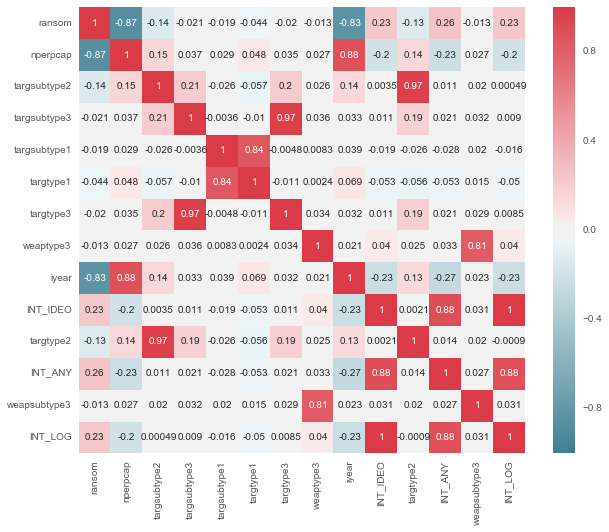

In [10]:
# Plot heat map for corr1
plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, annot = True, cbar=True, cmap=cmap)
plt.show()

In [11]:
# INT_ANY and INT_LOG have a correlation of 1, weaptypes and weapsubtypes are correlated as well.
# Except weaptype1, other weptype contains too many null values.

# subset1 - Basic information include year, month, country, region, attacktype, weaptype, targettype and gname
subset1 = sub_gtd[['country', 'region', 'date', 'iyear', 'imonth',
                   'attacktype1', 'weaptype1', 'weapsubtype1', 
                   'targtype1', 'targsubtype1', 'natlty1',
                   'doubtterr', 'alternative', 'multiple', 
                   'INT_ANY', 'INT_IDEO', 'specificity',
                   'nperps', 'nperpcap', 'property', 'propextent',
                   'ransom', 'suicide', 'ishostkid', 'vicinity', 'success', 
                   'gname']]

In [12]:
subset1.shape

(156771, 27)

## 3. Feature Engineering

### 3.1  Year

In [13]:
# After year 2011, there is a huge increase globally, the peak was in 2014, 16840 in total. 
gtd.groupby(['iyear']).iyear.count().nlargest(1)

iyear
2014    16840
Name: iyear, dtype: int64

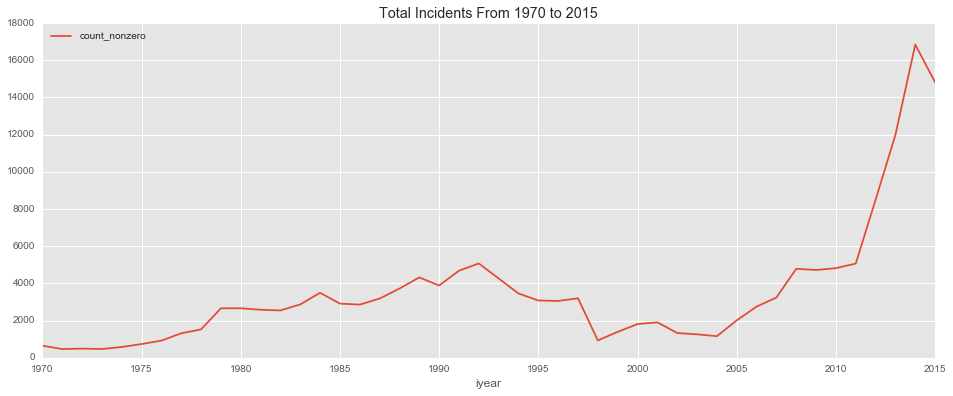

In [14]:
# Line chart of total incident by year
subset1.groupby(['iyear']).iyear.agg([np.count_nonzero]).plot(figsize=(16,6))
plt.title('Total Incidents From 1970 to 2015')
plt.show()

###  3.2 Class Balance

Groups are not evenly distributed, most of them have very few records, few of them have more, and huge number of 'Unknown'

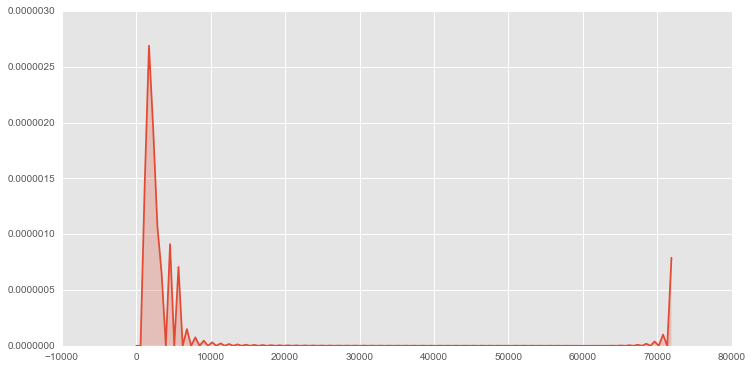

In [15]:
# Series of group name and their number of records
group_sr = subset1.groupby(['gname']).gname.size()

# Density plot see distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(group_sr, shade=True)
plt.show()

In [16]:
# Top 10 groups responsible to most incedents
gtd[gtd.gname != 'Unknown'].groupby(['gname']).gname.count().nlargest(10)

gname
Taliban                                             5502
Shining Path (SL)                                   4548
Farabundo Marti National Liberation Front (FMLN)    3351
Islamic State of Iraq and the Levant (ISIL)         2833
Irish Republican Army (IRA)                         2670
Revolutionary Armed Forces of Colombia (FARC)       2474
New People's Army (NPA)                             2241
Al-Shabaab                                          2127
Basque Fatherland and Freedom (ETA)                 2024
Boko Haram                                          1839
Name: gname, dtype: int64

In [17]:
# Check quantile points, except for Unknown group, Taliban is the largest with total records of 5502
group_sr[group_sr < 5503].quantile([0.25, 0.5, 0.75])

0.25    1.0
0.50    2.0
0.75    5.0
dtype: float64

Due to the unbalanceness, I would create subset whose total # of records is between 2 to 4, and another subset whose total is greater than 5 and is not 'Unknown'.

In [18]:
# Find indexes of each group
index_5 = group_sr[group_sr >= 5].index
index_2_4 = group_sr[(group_sr > 1) & (group_sr < 5)].index

# Create sub data frame based on their index
data_5 = subset1.loc[(subset1['gname'].isin(index_5)) & (subset1['gname'] != 'Unknown')]
data_2_4 = subset1.loc[(subset1['gname'].isin(index_2_4)) & (subset1['gname'] != 'Unknown')]

# Combine those two subsets
data = data_2_4.append(data_5)

In [19]:
data.shape

(83245, 27)

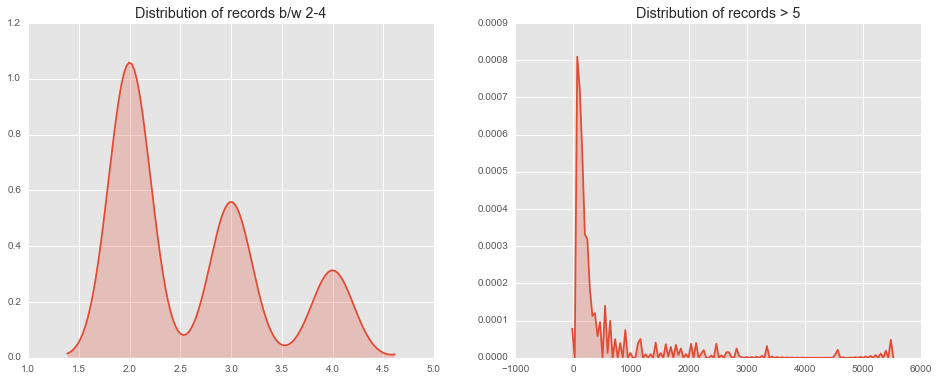

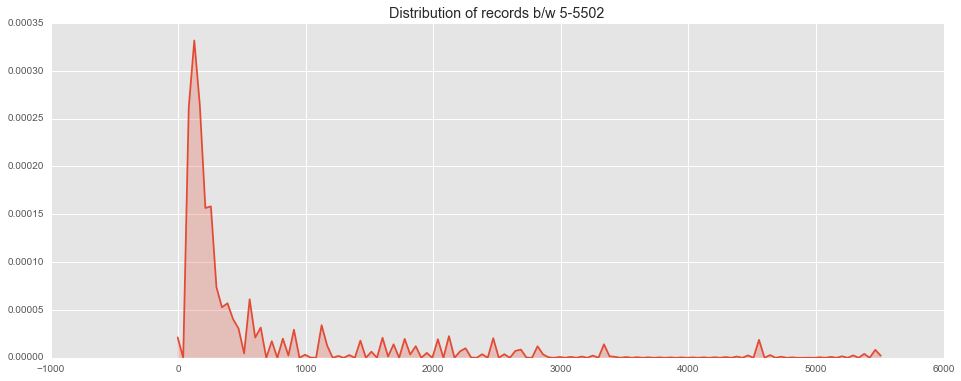

In [20]:
# Plot distribution of new subset
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.kdeplot(data_2_4.groupby(['gname']).gname.size(), shade=True)
plt.title('Distribution of records b/w 2-4')

plt.subplot(1,2,2)
sns.kdeplot(data_5.groupby(['gname']).gname.size(), shade=True)
plt.title('Distribution of records > 5')

plt.figure(figsize=(16, 6))
sns.kdeplot(data.groupby(['gname']).gname.size(), shade=True)
plt.title('Distribution of records b/w 5-5502')

plt.show()

In [21]:
# Top 10 countries with most incidents happened
gtd.groupby(['country_txt']).country_txt.count().nlargest(10)

country_txt
Iraq              18770
Pakistan          12768
India              9940
Afghanistan        9690
Colombia           8077
Peru               6085
Philippines        5576
El Salvador        5320
United Kingdom     4992
Turkey             3557
Name: country_txt, dtype: int64

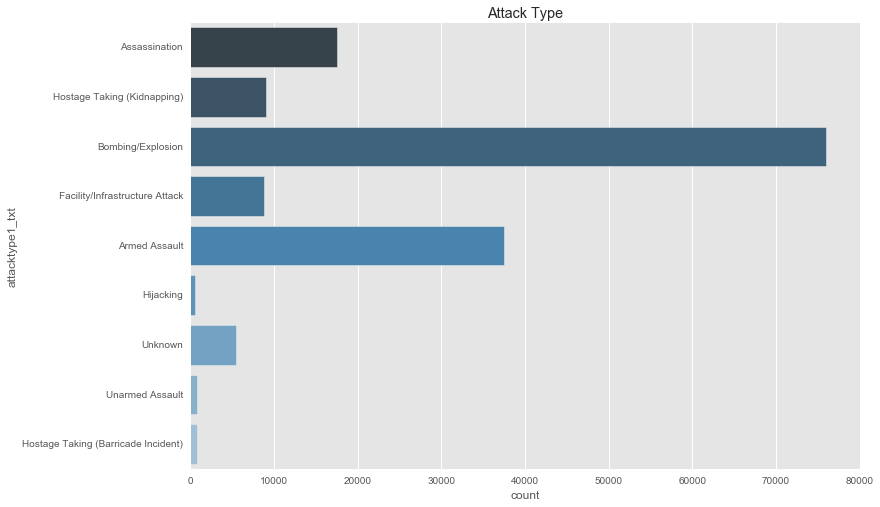

In [22]:
# Bombing is the most frequent happened attacktype
plt.figure(figsize=(12,8))
sns.countplot(y='attacktype1_txt', data=gtd, palette='Blues_d')
plt.title('Attack Type')
plt.show()

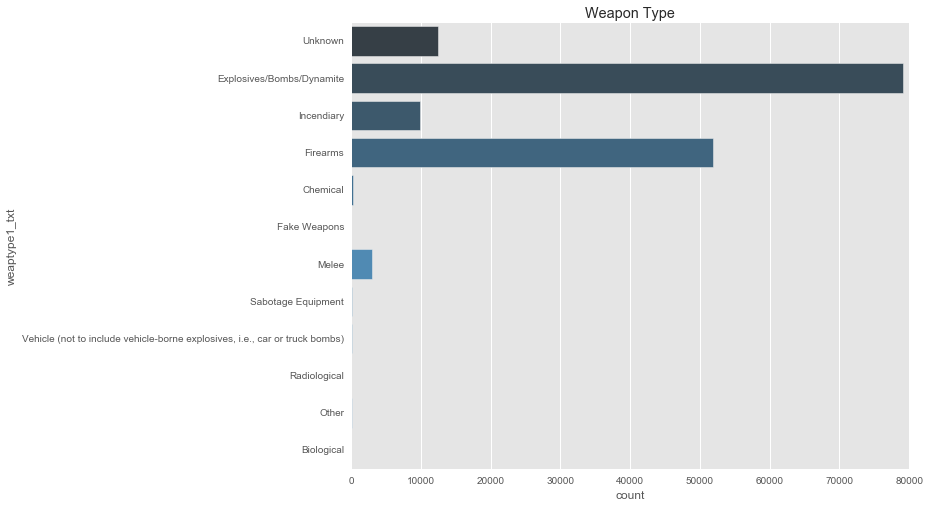

In [23]:
# Explosives/Bombs/Dynamite is the most frequent used weapon
plt.figure(figsize=(10,8))
sns.countplot(y='weaptype1_txt', data=gtd, palette='Blues_d')
plt.title('Weapon Type')
plt.show()

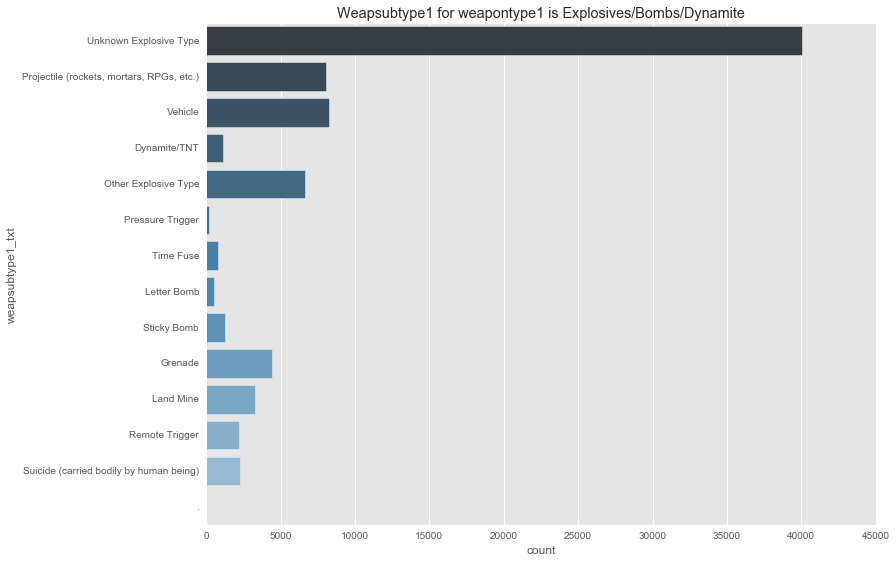

In [24]:
# Weapsubtype1 for weapontype1 is Explosives/Bombs/Dynamite
plt.figure(figsize=(12,9))
sns.countplot(y='weapsubtype1_txt', data=gtd[gtd.weaptype1==6], palette='Blues_d')
plt.title('Weapsubtype1 for weapontype1 is Explosives/Bombs/Dynamite')
plt.show()

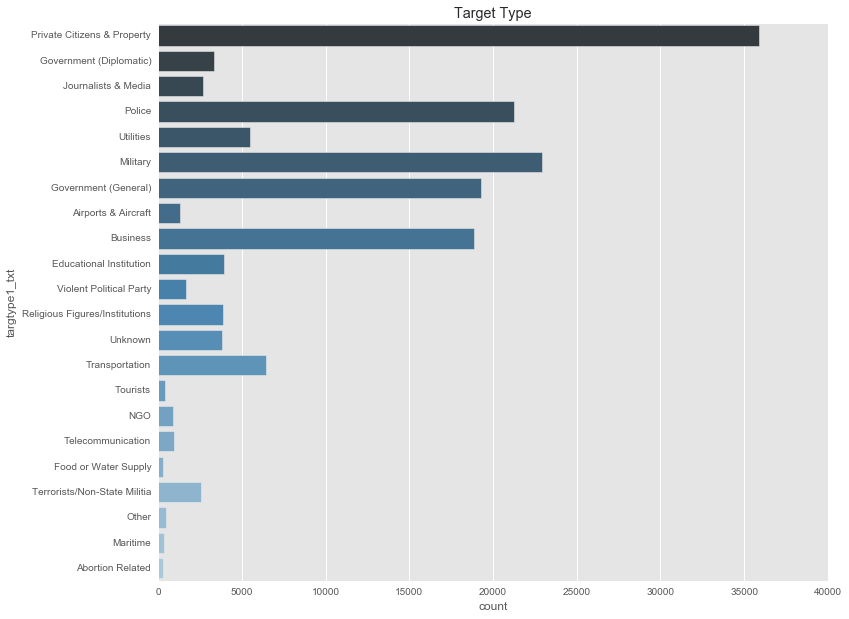

In [25]:
plt.figure(figsize=(12,10))
sns.countplot(y='targtype1_txt', data=gtd, 
              palette='Blues_d')
plt.title('Target Type')
plt.show()

## 4. Prediction

Since the data is unbalanced, in order to include all classes in both trainning and testing set, I will manully split the dataset. For class count under 5 rows, use 50/50; for class count greater than 5 rows, use 80/20.

In [26]:
random.seed(123123)

# Function to manually split dataset
def split(data, f):
    
    # Empty data frames
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    # Loop through all unique gnames and sampling
    for n in pd.unique(data.gname):        
        sub = data[data.gname == n]
        
        # Random sample f*100% as trainning set, and rest as testing set
        train_f = sub.sample(frac=f)
        test_f = sub.loc[~sub.index.isin(train_f.index)]
        
        train = train.append(train_f, ignore_index=True)
        test = test.append(test_f, ignore_index=True)
        
    return train, test       

In [29]:
# Create train and test sets
train_5, test_5 = split(data_5, 0.8)
train_2_4, test_2_4 = split(data_2_4, 0.5)

# Append to one train and test set as X and y
X = train_5.append(train_2_4)
y = test_5.append(test_2_4)

# Split into final trainning and testing set
X_train = X.drop('gname', axis=1)
X_test = y.drop('gname', axis=1)
y_train = X.gname
y_test = y.gname

In [30]:
# Random Forest
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Accuracy score
rf_scores = cross_val_score(rf, X_test, y_test, cv=5, n_jobs=-1)

# F1 score
# F1 = 2 * (precision * recall) / (precision + recall)
rf_f1 = f1_score(y_test, y_pred, average='weighted')

# Precision
rf_precision = precision_score(y_test, y_pred, average='weighted')

# Recall
rf_recall = recall_score(y_test, y_pred, average='weighted')

print "Random Forest Results: "
print "Accuracy: %.2f%%" % (rf_scores.mean() * 100.0) 
print "F1: %.2f%%" % (rf_f1 * 100.0)
print "Precision: %.2f%%" % (rf_precision * 100.0)
print "Recall: %.2f%%" % (rf_recall * 100.0)

Random Forest Results: 
Accuracy: 57.38%
F1: 76.64%
Precision: 75.51%
Recall: 78.91%


In [31]:
# Feature Importance
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

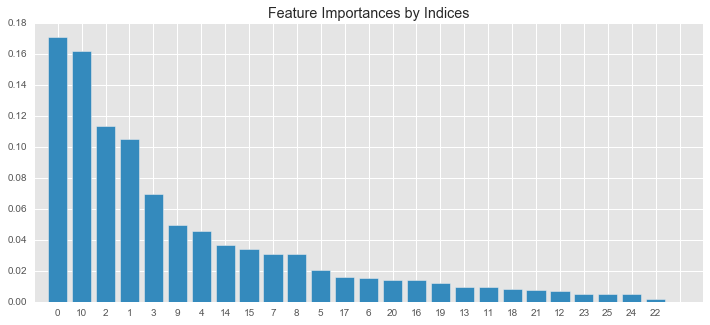

In [32]:
plt.figure(figsize=(12,5))
plt.title("Feature Importances by Indices")
plt.bar(range(X_train.shape[1]), importances[indices],
        yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [33]:
# Feature names sorted by importance
data.columns[indices]

Index([     u'country',      u'natlty1',         u'date',       u'region',
              u'iyear', u'targsubtype1',       u'imonth',      u'INT_ANY',
           u'INT_IDEO', u'weapsubtype1',    u'targtype1',  u'attacktype1',
             u'nperps',    u'weaptype1',   u'propextent',  u'specificity',
           u'property',     u'multiple',    u'doubtterr',     u'nperpcap',
             u'ransom',  u'alternative',    u'ishostkid',      u'success',
           u'vicinity',      u'suicide'],
      dtype='object')

In [364]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Accuracy score
knn_scores = cross_val_score(knn, X_test, y_test, cv=5, n_jobs=-1)

# Since the dataset is highly unbalanced, use f1 score is more accurate
# F1 = 2 * (precision * recall) / (precision + recall)
knn_f1 = f1_score(y_test, y_pred, average='weighted')

# Precision
knn_precision = precision_score(y_test, y_pred, average='weighted')

# Recall
knn_recall = recall_score(y_test, y_pred, average='weighted')

print "KNN Results: "
print "Accuracy: %.2f%%" % (knn_scores.mean() * 100.0) 
print "F1: %.2f%%" % (knn_f1 * 100.0)
print "Precision: %.2f%%" % (knn_precision * 100.0)
print "Recall: %.2f%%" % (knn_recall * 100.0)

KNN Results: 
Accuracy: 7.35%
F1: 57.97%
Precision: 56.71%
Recall: 60.48%


In [ ]:
# SVC

# svc = SVC(C=1.0, kernel='rbf', gamma='auto')
# svc = svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)

# # Accuracy score
# svc_scores = cross_val_score(svc, X_test, y_test, cv=5, n_jobs=-1)

# # Since the dataset is highly unbalanced, use f1 score is more accurate
# # F1 = 2 * (precision * recall) / (precision + recall)
# svc_f1 = f1_score(y_test, y_pred, average='weighted')

# # Precision
# svc_precision = precision_score(y_test, y_pred, average='weighted')

# # Recall
# svc_recall = recall_score(y_test, y_pred, average='weighted')

# print "SVC Results: "
# print "Accuracy: %.2f%%" % (svc_scores.mean() * 100.0) 
# print "F1: %.2f%%" % (svc_f1 * 100.0)
# print "Precision: %.2f%%" % (svc_precision * 100.0)
# print "Recall: %.2f%%" % (svc_recall * 100.0)

In [ ]:
# Xgboost

# import xgboost as xgb

# X = X.drop('date', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, 
#                           silent=True, objective='binary:logistic', booster='gbtree', 
#                           n_jobs=-1, nthread=None, gamma=0, 
#                           min_child_weight=1, max_delta_step=0, subsample=1, 
#                           colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
#                           reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
#                           random_state=0, seed=None, missing=None)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))